In [21]:
import numpy as np
from PIL import Image
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

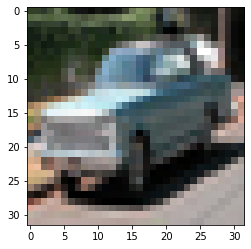

In [16]:
from utils import COLORS, load_image

class GMM:
    def __init__(self, ncomp, initial_mus, initial_covs, initial_priors):
        self.ncomp = ncomp
        self.mus = np.asarray(initial_mus)
        self.covs = np.asarray(initial_covs)
        self.priors = np.asarray(initial_priors)

    def inference(self, datas): # E-step
        unnormalized_probs = []
        for i in range(self.ncomp):
            mu, cov, prior = self.mus[i, :], self.covs[i, :, :], self.priors[i]
            unnormalized_prob = prior * multivariate_normal.pdf(datas, mean=mu, cov=cov)
            unnormalized_probs.append(np.expand_dims(unnormalized_prob, -1))
        preds = np.concatenate(unnormalized_probs, axis=1)
        log_likelihood = np.sum(preds, axis=1)
        log_likelihood = np.sum(np.log(log_likelihood))

        preds = preds / np.sum(preds, axis=1, keepdims=True)
        return np.asarray(preds), log_likelihood

    def update(self, datas, beliefs): # M-step
        new_mus, new_covs, new_priors = [], [], []
        soft_counts = np.sum(beliefs, axis=0)
        for i in range(self.ncomp):
            new_mu = np.sum(np.expand_dims(beliefs[:, i], -1) * datas, axis=0)
            new_mu /= soft_counts[i]
            new_mus.append(new_mu)

            data_shifted = np.subtract(datas, np.expand_dims(new_mu, 0))
            new_cov = np.matmul(np.transpose(np.multiply(np.expand_dims(beliefs[:, i], -1), data_shifted)), data_shifted)
            new_cov /= soft_counts[i]
            new_covs.append(new_cov)

            new_priors.append(soft_counts[i] / np.sum(soft_counts))

        self.mus = np.asarray(new_mus)
        self.covs = np.asarray(new_covs)
        self.priors = np.asarray(new_priors)
        

# Load image
image_name = '33'
image_path = '../data/train/{}.png'.format(image_name)
image = load_image(image_path)
image_height, image_width, image_channels = image.shape
image_pixels = np.reshape(image, (-1, image_channels))
plt.imshow(image)

Iteration 1: Log Likelihood = -888.3438903951351
Iteration 2: Log Likelihood = -793.0597678730245
Iteration 3: Log Likelihood = -759.8016530324196
Iteration 4: Log Likelihood = -733.9590369807845
Iteration 5: Log Likelihood = -707.293069011819
Iteration 6: Log Likelihood = -673.5041673822464
Iteration 7: Log Likelihood = -633.0355471553655
Iteration 8: Log Likelihood = -597.1840306408641
Iteration 9: Log Likelihood = -561.2666190331865
Iteration 10: Log Likelihood = -528.2746802867089
Iteration 11: Log Likelihood = -510.2988763668745
Iteration 12: Log Likelihood = -503.58010149102853
Iteration 13: Log Likelihood = -501.1722409761384
Iteration 14: Log Likelihood = -500.29061627421294
Iteration 15: Log Likelihood = -499.96835458294396
Iteration 16: Log Likelihood = -499.8511766325555
Iteration 17: Log Likelihood = -499.8087206321203
Iteration 18: Log Likelihood = -499.7933705651468
Iteration 19: Log Likelihood = -499.78782795689597
Iteration 20: Log Likelihood = -499.7858283074901
Iterat

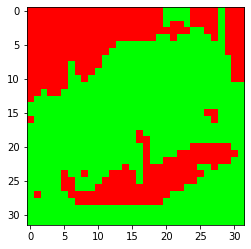

In [18]:
_mean = np.mean(image_pixels,axis=0,keepdims=True)
_std = np.std(image_pixels,axis=0,keepdims=True)
image_pixels = (image_pixels - _mean) / _std # Normalization

# Input number of classes
ncomp = 2

# Apply K-Means to find the initial weights and covariance matrices for GMM
kmeans = KMeans(n_clusters=ncomp)
labels = kmeans.fit_predict(image_pixels)
initial_mus = kmeans.cluster_centers_
initial_priors, initial_covs = [], []
for i in range(ncomp):
    datas = np.array([image_pixels[j, :] for j in range(len(labels)) if labels[j] == i]).T
    initial_covs.append(np.cov(datas))
    initial_priors.append(datas.shape[1] / float(len(labels)))

# Initialize a GMM
gmm = GMM(ncomp, initial_mus, initial_covs, initial_priors)

# EM Algorithm
log_likelihood_list=[]
prev_log_likelihood = None
for i in range(1000):
    beliefs, log_likelihood = gmm.inference(image_pixels) # E-step
    gmm.update(image_pixels, beliefs)   # M-step
    print('Iteration {}: Log Likelihood = {}'.format(i+1, log_likelihood))
    if prev_log_likelihood != None and abs(log_likelihood - prev_log_likelihood) < 1e-10:
        break
    prev_log_likelihood = log_likelihood
    log_likelihood_list.append(log_likelihood)

# Show Result
beliefs, log_likelihood = gmm.inference(image_pixels)
map_beliefs = np.reshape(beliefs, (image_height, image_width, ncomp))
segmented_map = np.zeros((image_height, image_width, 3))
for i in range(image_height):
    for j in range(image_width):
        hard_belief = np.argmax(map_beliefs[i, j, :])
        segmented_map[i,j,:] = np.asarray(COLORS[hard_belief]) / 255.0
plt.imshow(segmented_map)
plt.show()

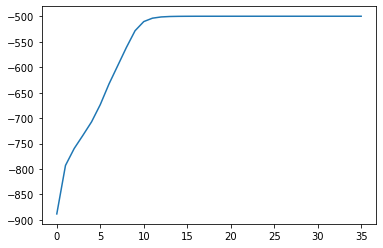

In [15]:
plt.plot(log_likelihood_list)

C:\Users\Saurav\Documents\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density plot for probability of pixel belonging to the first component Z')

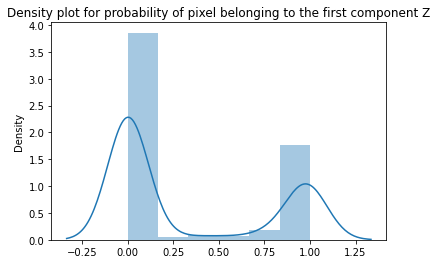

In [25]:
sns.distplot([x[0] for x in beliefs])
plt.title("Density plot for probability of pixel belonging to the first component Z")

C:\Users\Saurav\Documents\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density plot for probability of pixel belonging to the second component Z')

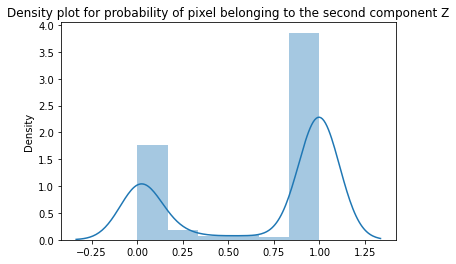

In [26]:
sns.distplot([x[1] for x in beliefs])
plt.title("Density plot for probability of pixel belonging to the second component Z")

In [27]:
image_pixels.shape

(1024, 3)

In [35]:
image_pixels[0:,1].shape

(1024,)

C:\Users\Saurav\Documents\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density plot for R channel')

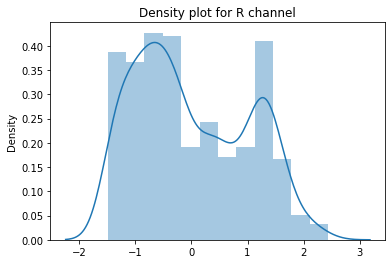

In [50]:
sns.distplot(image_pixels[0:,0])
plt.title("Density plot for R channel")

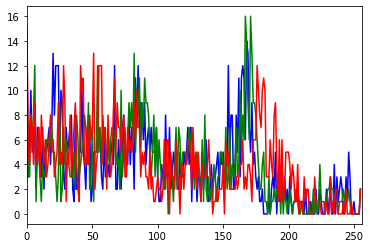

In [28]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('../data/train/{}.png'.format(image_name))
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()